In [1]:
using LinearAlgebra
using Symbolics

In [34]:
h = 0.01
g = 9.81
m1 = 1.0
m2 = 1.0
ℓ1 = 1.0
ℓ2 = 1.0
J1 = (1.0/12)*m1*ℓ1*ℓ1
J2 = (1.0/12)*m2*ℓ2*ℓ2

0.08333333333333333

In [35]:
#Kinematics Functions

function link2_kinematics(q)
    x1 = q[1]
    y1 = q[2]
    θ1 = q[3]
    θ2 = q[4]
    
    x2 = x1 - 0.5*ℓ1*sin(θ1) - 0.5*ℓ2*sin(θ2)
    y2 = y1 + 0.5*ℓ1*cos(θ1) + 0.5*ℓ2*cos(θ2)
    
    return [x2; y2]
end

function foot_kinematics(q)
    x1 = q[1]
    y1 = q[2]
    θ1 = q[3]
    
    xf = x1 + 0.5*ℓ1*sin(θ1)
    yf = y1 - 0.5*ℓ1*cos(θ1)
    
    return [xf; yf]
end

foot_kinematics (generic function with 1 method)

In [36]:
#Fast Kinematics Functions

@variables q[1:4]
@variables q̇[1:4]
@variables u[1:2] #torque inputs on links 1 and 2
@variables f[1:2] #contact force on foot (end of link 1)

klink2 = link2_kinematics(q)
klink2_expr = Symbolics.build_function(klink2, q)
k2_func = eval(klink2_expr[1])

kfoot = foot_kinematics(q)
kfoot_expr = Symbolics.build_function(kfoot, q)
kfoot_func = eval(kfoot_expr[1])

#35 (generic function with 1 method)

In [37]:
#Kinematics Jacobians

J2 = Symbolics.jacobian(klink2, q, simplify = true)
Jf = Symbolics.jacobian(kfoot, q, simplify = true)

J2_expr = Symbolics.build_function(J2, q)
Jf_expr = Symbolics.build_function(Jf, q)

J2_func = eval(J2_expr[1])
Jf_func = eval(Jf_expr[1])

#39 (generic function with 1 method)

In [38]:
#Lagrangian
function lagrangian(q, q̇)
    L = 0.0

    # Link 1
    v1 = 
    L += 0.5*m1*transpose(q̇[1:2])*q̇[1:2] + 0.5*J1*q̇[3]*q̇[3] #kinetic energy
    L -= m1*g*q[2] #potential energy

    # Link 2
    v2 = J2_func(q)*q̇
    L += 0.5*m2*transpose(v2)*v2
    L -= m2*g*k2_func(q)[2]

    return L
end

lagrangian (generic function with 1 method)

In [39]:
#Lagrangian derivatives
L = lagrangian(q, q̇)
dLq = Symbolics.gradient(L, q, simplify = true)
dLq̇ = Symbolics.gradient(L, q̇, simplify = true)
d2L = Symbolics.hessian(L, [q; q̇], simplify = true)

#mass matrix
M = d2L[4 .+ (1:4), 4 .+ (1:4)]
M = simplify.(M)

#dynamics bias
C = d2L[4 .+ (1:4), 1:4] * q̇ - dLq
C = simplify.(C)

#input jacobian
B = [0.0 0.0; 0.0 0.0; 1.0 0.0; 0.0 1.0]

# continuous-time dynamics
ẋ = [q̇; M\(B*u + transpose(Jf)*f - C)]
ẋ = simplify.(ẋ)

ẋ_expr = Symbolics.build_function(ẋ, [q; q̇], u, f)

dynamics = eval(ẋ_expr[1])

#41 (generic function with 1 method)

In [88]:
q0 = [0.0; ℓ1/2; 0; 0]
q̇0 = [0.0; 0; 0; 0]
x0 = [q0; q̇0]
u0 = [0.0; 0.0]
f0 = [0.0; 2*9.81] #gravity compensation

dynamics(x0,u0,f0) #should be zero

8-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [89]:
# continuous-time dynamics derivatives

dẋ = Symbolics.jacobian(ẋ, [q; q̇; u; f]);
dx = simplify(dẋ[:,1:8])
du = simplify(dẋ[:,9:10])
df = simplify(dẋ[:,11:12])

Ac_expr = Symbolics.build_function(dx, [q; q̇], u, f)
Bc_expr = Symbolics.build_function(du, [q; q̇], u, f)
Cc_expr = Symbolics.build_function(df, [q; q̇], u, f)

Ac = eval(Ac_expr[1])
Bc = eval(Bc_expr[1])
Cc = eval(Cc_expr[1])

#59 (generic function with 1 method)

In [90]:
#Discrete-time dynamics with foot pinned at the origin
function implicit_euler(x,u)
    xn = x
    f = zeros(2)
    
    r = [xn - x - h.*dynamics(xn,u,f); foot_kinematics(xn)]
    
    while maximum(abs.(r)) > 1e-12
        dr = [I-h.*Ac(xn,u,f) -h.*Cc(xn,u,f); Jf_func(xn[1:4]) zeros(2,6)]
        dz = -dr\r
        xn += dz[1:8]
        f += dz[9:10]
        r = [xn - x - h.*dynamics(xn,u,f); foot_kinematics(xn)]
    end
    
    return xn
end

implicit_euler (generic function with 1 method)

In [102]:
#q0 = [0.0; ℓ1/2; 0; 1e-5] #tiny perturbation from upright
q0 = [0.0; -ℓ1/2; pi; pi+1e-3] #tiny perturbation from hanging down
q̇0 = [0.0; 0; 0; 0]
x0 = [q0; q̇0]
u0 = [0.0; 0.0]

N = 1000

xhist = zeros(8,N)
xhist[:,1] .= x0

for k = 1:(N-1)
    xhist[:,k+1] .= implicit_euler(xhist[:,k],[1e-1; 0])
end

In [103]:
using PyPlot

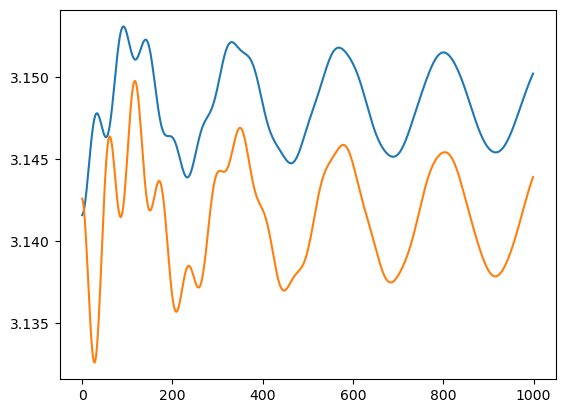

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8c949f1d00>

In [104]:
plot(xhist[3,:])
plot(xhist[4,:])

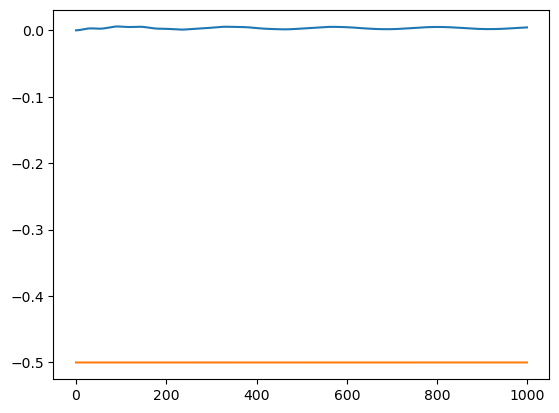

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8c95157d90>

In [101]:
plot(xhist[1,:])
plot(xhist[2,:])